# Calibration

In [15]:
import numpy as np
import pandas as pd
import numpy as np
from os.path import join
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

# custom functions to run the calibration simulations
import calibration_functions as cf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

In [7]:
! ls ../../../COVID_schools/analysis/data

calibration			     sensitivity_analysis_old.zip
contact_networks		     sensitivity_analysis_prerevision.zip
documents			     sensitivity_analysis.zip
intervention_measures_delta_old.zip  tables
intervention_measures_delta.zip      vaccinations.zip
intervention_measures_wild_type.zip  visualization
plots


In [8]:
empirical_data_src = '../../../COVID_schools/analysis/data/calibration/empirical_observations'

# distribution of outbreak sizes by school type
outbreak_sizes = pd.read_csv(\
            join(empirical_data_src, 'empirical_outbreak_sizes.csv'))
# ratio of infections in the student and teacher groups
group_distributions = pd.read_csv(\
            join(empirical_data_src, 'empirical_group_distributions.csv'))
# ratio of index cases in the student and teacher groups
agent_index_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_index_case_ratios.csv'))
agent_index_ratios.index = agent_index_ratios['school_type']
# ratio of symptomatic cases in the student and teacher groups
symptomatic_case_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_symptomatic_case_ratios.csv'))

In [18]:
# note: these are the number of clusters per school type from the slightly older
# data version (November 2020). For primary and lower secondary school types,
# the counts are split evenly between schools with and without daycare. 
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary'],
                      'count':[33.5, 33.5, 90, 90, 116, 70]})

counts.index = counts['type']
counts = counts.drop(columns=['type'])
# The cluster counts are used to weigh the respective school type in the 
# calibration process.
counts['weight'] = counts['count'] / counts['count'].sum()

In [10]:
N_runs = 4000

# school types over which the calibration us run
school_types = ['upper_secondary', 'secondary']

opt_contact_weight_coarse = 0.290

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search, passed to the script via the command line.
contact_weights_fine = np.hstack([
    np.arange(opt_contact_weight_coarse - 0.06, 
              opt_contact_weight_coarse, 0.01),
    np.arange(opt_contact_weight_coarse, 
              opt_contact_weight_coarse + 0.061, 0.01)
    ])

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts_fine = [0.00, -0.0025, -0.005, -0.0075, -0.01,
                                   -0.0125, -0.015, -0.0175, -0.02,
                                   -0.0225, -0.025, -0.0275, -0.03]

contact_weights_fine = np.asarray([round(i, 2) \
            for i in contact_weights_fine])

# list of all possible parameter combinations from the grid
screening_params = [(N_runs, i, j, j, k) for i in school_types \
                    for j in contact_weights_fine \
                    for k in age_transmission_discounts_fine]

In [16]:
# calculate the various distribution distances between the simulated and
# observed outbreak size distributions
src = '../../../COVID_schools/analysis/data/calibration/simulation_results/ensembles_fine_ensemble_distributions'

results_fine = pd.DataFrame()
for i, ep in enumerate(screening_params):
    _, school_type, icw, fcw, atd = ep
    if i % 100 == 0:
        print('{}/{}'.format(i, len(screening_params)))
    fname = 'school_type-{}_icw-{:1.2f}_fcw-{:1.2f}_atd-{:1.4f}_infected.csv'\
        .format(school_type, icw, fcw, atd)
    ensemble_results = pd.read_csv(join(src, fname), 
            dtype={'infected_students':int, 'infected_teachers':int,
                   'infected_total':int, 'run':int})
    row = cf.calculate_distances(ensemble_results, school_type, icw, fcw, atd,
                       outbreak_sizes, group_distributions)
    
    results_fine = results_fine.append(row, ignore_index=True)

0/338
100/338
200/338
300/338


In [17]:
# collection of different distance metrics to try
distance_cols = [
    'sum_of_squares',
    'chi2_distance',
    'bhattacharyya_distance',
    'spearmanr_difference',
    'pearsonr_difference',
    'pp_difference',
    'qq_difference',
]

In [19]:
results_fine = results_fine.sort_values(by=['school_type',
                'intermediate_contact_weight', 'age_transmission_discount'])
results_fine = results_fine.reset_index(drop=True)

for col in distance_cols:
    results_fine[col + '_total'] = results_fine[col + '_size'] + \
                    results_fine['sum_of_squares_distro']
    results_fine[col + '_total_weighted'] = results_fine[col + '_total']
    
    for i, row in results_fine.iterrows():
        st = row['school_type']
        weight = counts.loc[st, 'weight']
        error = row[col + '_total']
        results_fine.loc[i, col + '_total_weighted'] = error * weight

In [20]:
agg_results_fine = results_fine\
    .drop(columns=['far_contact_weight'])\
    .rename(columns={'intermediate_contact_weight':'contact_weight'})\
    .groupby(['contact_weight',
              'age_transmission_discount'])\
    .sum()

for col in distance_cols:
    print(col)
    opt_fine = agg_results_fine.loc[\
            agg_results_fine[col + '_total_weighted'].idxmin()].name
    opt_contact_weight_fine = opt_fine[0]
    opt_age_transmission_discount_fine = opt_fine[1]

    print('optimal grid search parameter combination:')
    print('\t contact weight: {:1.3f}'\
          .format(opt_contact_weight_fine))
    print('\t age transmission discount: {:1.4f}'\
          .format(opt_age_transmission_discount_fine))
    print()

sum_of_squares
optimal grid search parameter combination:
	 contact weight: 0.260
	 age transmission discount: 0.0000

chi2_distance
optimal grid search parameter combination:
	 contact weight: 0.260
	 age transmission discount: 0.0000

bhattacharyya_distance
optimal grid search parameter combination:
	 contact weight: 0.240
	 age transmission discount: -0.0300

spearmanr_difference
optimal grid search parameter combination:
	 contact weight: 0.230
	 age transmission discount: -0.0075

pearsonr_difference
optimal grid search parameter combination:
	 contact weight: 0.250
	 age transmission discount: 0.0000

pp_difference
optimal grid search parameter combination:
	 contact weight: 0.240
	 age transmission discount: -0.0050

qq_difference
optimal grid search parameter combination:
	 contact weight: 0.320
	 age transmission discount: -0.0225



In [21]:
# compose matrices of the distance measurements for all different distance
# metrics which are calculated as sum between the first component (ratio of
# infected students and teachers) and the second component (outbreak size
# distribution)
distance_images = {}
for col in distance_cols:
    img_fine = np.zeros((len(contact_weights_fine),
                    len(age_transmission_discounts_fine)))
    for i, cw in enumerate(contact_weights_fine):
        for j, atd in enumerate(age_transmission_discounts_fine):
            cw = round(cw, 2)
            atd = round(atd, 4)
            try:
                img_fine[i, j] = agg_results_fine\
                    .loc[cw, atd][col + '_total_weighted']
            except KeyError:
                print(atd)
                img_fine[i, j] = np.nan
    distance_images[col] = img_fine

In [24]:
# qq and spearman are super noisy, exclude them for further analysis
distance_col_names = {
    'sum_of_squares':'Sum of squares',
    'chi2_distance':'$\\chi^2$',
    'bhattacharyya_distance':'Bhattacharyya',
    'spearmanr_difference': 'Spearman correlation',
    'pearsonr_difference':'Pearson correlation',
    'pp_difference':'pp-slope',
    'qq_difference':'qq-slope'
}

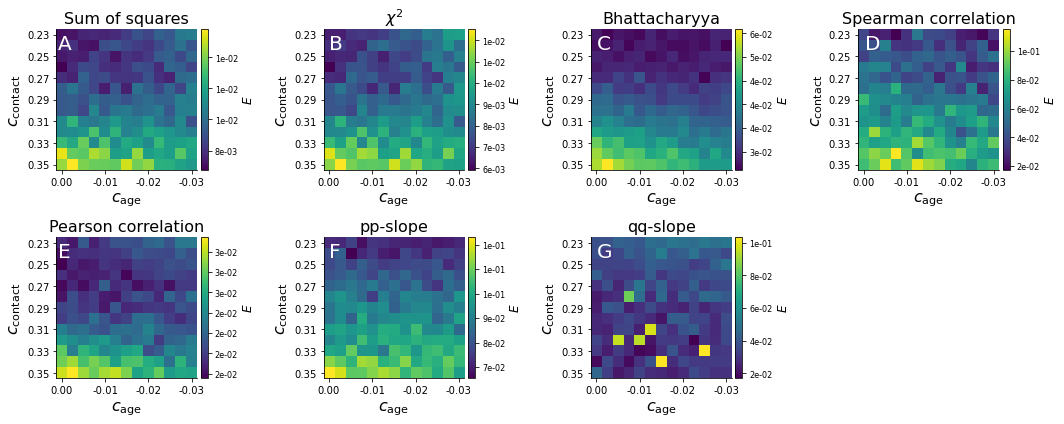

In [26]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

for ax, col in zip(axes.flatten(), distance_col_names.keys()):
    img_fine = distance_images[col]
    im = ax.imshow(img_fine)
    ax.set_yticks(range(len(contact_weights_fine))[::2])
    ax.set_yticklabels(['{:1.2f}'.format(cw) for \
                        cw in contact_weights_fine[::2]])
    #ax.set_xticks(range(len(age_transmission_discounts_fine))[::2])
    ax.set_xticks([0, 4, 8, 12])
    ax.set_xticklabels(['0.00', '-0.01', '-0.02', '-0.03'])
    #ax.set_xticklabels(['{:1.4f}'.format(atd) for \
    #                    atd in age_transmission_discounts_fine[::2]],
    #                    fontsize=8)
    ax.set_title(distance_col_names[col], fontsize=16)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', format='%.0e')
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('$E$', fontsize=12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('$c_\\mathrm{contact}$', fontsize=16)
    ax.set_xlabel('$c_\\mathrm{age}$', fontsize=16)

axes[1, 3].axis('off')

fig.text(0.061, 0.875, 'A', color='w', fontsize=20)
fig.text(0.312, 0.875, 'B', color='w', fontsize=20)
fig.text(0.56, 0.875, 'C', color='w', fontsize=20)
fig.text(0.808, 0.875, 'D', color='w', fontsize=20)
fig.text(0.061, 0.395, 'E', color='w', fontsize=20)
fig.text(0.312, 0.395, 'F', color='w', fontsize=20)
fig.text(0.56, 0.395, 'G', color='w', fontsize=20)

fig.tight_layout()
#plt.savefig('../../data/plots/calibration/distances_heatmap.pdf')